In [1]:
from skimage import io
from skimage import img_as_float

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [227]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from models.prepare_train_val import get_split
from models.transforms import (DualCompose,
                        ImageOnly,
                        Normalize,
                        HorizontalFlip,
                        VerticalFlip,
                        Rotate,
                        RandomBrightness,
                        RandomContrast,
                        AddMargin)

from skimage.io import imread

from models.dataset import SaltDataset

from albumentations import (HorizontalFlip, VerticalFlip, Normalize,
    ShiftScaleRotate, Blur, OpticalDistortion,  GridDistortion, HueSaturationValue, IAAAdditiveGaussianNoise, GaussNoise, MotionBlur,
    MedianBlur, IAAPiecewiseAffine, IAASharpen, IAAEmboss, RandomContrast, RandomBrightness,IAAPerspective, ElasticTransform,
    InvertImg, Flip, OneOf, Compose,CLAHE, ImageOnlyTransform, RGBShift,
)

from albumentations.augmentations import functional as F

def mask_overlay(image, mask, color=(0, 1, 0)):
    """
    Helper function to visualize mask on the top of the image
    """
    mask = np.dstack((mask, mask, mask)) * np.array(color)
    weighted_sum = cv2.addWeighted(mask, 0.5, image, 0.5, 0.)
    img = image.copy()
    ind = mask[:, :, 1] > 0
    img[ind] = weighted_sum[ind]    
    return img

def imshow(img, mask, title=None):
    """Imshow for Tensor."""
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    mask = mask.numpy().transpose((1, 2, 0))
    mask = np.clip(mask, 0, 1)
    fig = plt.figure(figsize = (12,6))
    fig.add_subplot(1,2,1)
    plt.imshow(mask_overlay(img, mask))
    fig.add_subplot(1,2,2)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 


In [5]:
import os
os.chdir('../')

In [6]:
train_ids, val_ids = get_split(0)

In [7]:
def train_transform(p=1):
        return Compose([
            #PadIfNeeded(min_height=args.train_crop_height, min_width=args.train_crop_width, p=1),
            HorizontalFlip(p=0.5),
            OneOf([
                IAAAdditiveGaussianNoise(),
                GaussNoise(),
            ], p=0.2),
            OneOf([
                MotionBlur(p=0.2),
                MedianBlur(blur_limit=3, p=0.1),
                Blur(blur_limit=3, p=0.1),
            ], p=0.2),
            ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=0, p=0.2),
            OneOf([
                OpticalDistortion(p=0.3),
                GridDistortion(p=0.1),
                IAAPiecewiseAffine(p=0.3),
            ], p=0.2),
            OneOf([
                CLAHE(clip_limit=2),
                IAASharpen(),
                IAAEmboss(),
                RandomContrast(),
                RandomBrightness(),
            ], p=0.3),
            Normalize(p=1)
        ], p=p)


In [7]:
 train_loader = DataLoader(
        dataset=SaltDataset(train_ids, transform=None),
        shuffle=True,
        num_workers=1,
        batch_size=10,
        pin_memory=False)

TypeError: __init__() missing 1 required positional argument: 'config'

In [ ]:
img1, mask1 = next(iter(train_loader))
imshow(img1[0], mask1[0])

In [10]:
mask1[0].shape

torch.Size([1, 128, 128])

In [11]:
(mask1[0]==1).sum()

4546

In [9]:
id_ = '0b73b427d1.png'
img = io.imread('data/train/images/'+ id_)
mask = io.imread('data/train/masks/'+ id_)

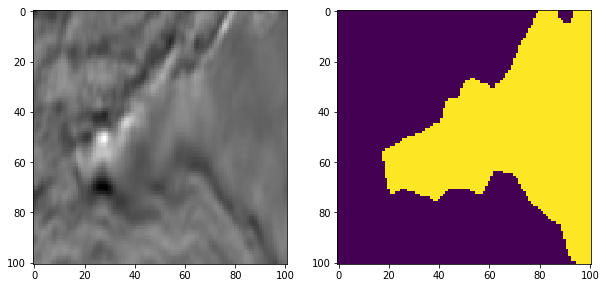

In [145]:
fig = plt.figure(figsize = (10,5))
fig.add_subplot(1,2,1)
plt.imshow(img)
fig.add_subplot(1,2,2)
plt.imshow((mask >0))

In [11]:
 data = {"image": img, "mask": mask}

In [228]:
class ShiftBrightness(ImageOnlyTransform):
    def __init__(self, shift_limit=(5,20), p=0.5):
        super(ShiftBrightness, self).__init__(p)
        self.limit = shift_limit
        
    def apply(self, image, shift=0,  **params):
        return F.shift_rgb(image, shift, shift, shift)

    def get_params(self):
        return {'shift': random.uniform(self.limit[0], self.limit[1])}
               
    


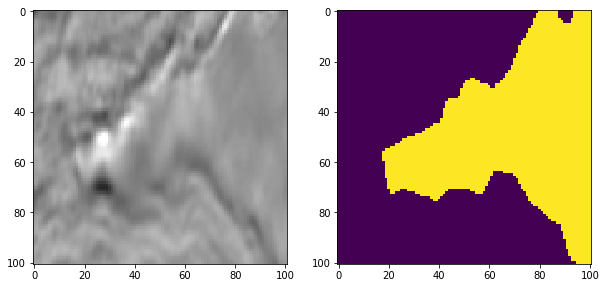

In [246]:

#transform = ShiftScaleRotate(shift_limit=0, scale_limit=0.2, rotate_limit=10, p=1)
transform =ShiftBrightness((20,50),1)
    
augmented = transform(image = img, mask = mask)
img1, mask1 = augmented["image"], augmented["mask"]
fig = plt.figure(figsize = (10,5))
fig.add_subplot(1,2,1)
plt.imshow(img1)
fig.add_subplot(1,2,2)
plt.imshow((mask1 >0))

In [184]:
img.min()

0

In [193]:
img1.max()

255

In [25]:
img2 = io.imread('data/train/images/'+ id_)

In [27]:
img2[:,:,0]/255

array([[0.19607843, 0.24705882, 0.31764706, ..., 0.39215686, 0.34901961,
        0.36470588],
       [0.23529412, 0.28627451, 0.32941176, ..., 0.38823529, 0.35686275,
        0.37647059],
       [0.30588235, 0.34509804, 0.34901961, ..., 0.39215686, 0.37254902,
        0.39215686],
       ...,
       [0.45490196, 0.44313725, 0.45098039, ..., 0.45098039, 0.46666667,
        0.4627451 ],
       [0.47058824, 0.4627451 , 0.47058824, ..., 0.42745098, 0.45098039,
        0.45098039],
       [0.49411765, 0.48627451, 0.48627451, ..., 0.4       , 0.43137255,
        0.43529412]])

In [ ]:
pred_dir = 'data/predictions/AlbuNet/OOF/'
train_dir = 'data/train/'
def show_image(file_name):
    global mask, mask_pred
    img = imread(train_dir + "images/" + file_name)
    mask = imread(train_dir + "masks/" + file_name)
    mask_pred = img_as_float(imread(pred_dir + file_name))
    fig = plt.figure(figsize = (18,6))
    fig.add_subplot(1,4,1)
    plt.imshow(img)
    fig.add_subplot(1,4,2)
    plt.imshow(mask)
    fig.add_subplot(1,4,3)
    plt.imshow(mask_pred)
    fig.add_subplot(1,4,4)
    plt.imshow((mask_pred>0.2))
#show_image('6c793e5879.png')
#show_image('6a1fe1a81e.png')
show_image('fd1be18f7d.png')

In [ ]:
mask.shape

In [ ]:
(mask_pred>0).sum()

In [ ]:
mask_pred.dtype

In [ ]:
mask.max()

In [ ]:
mask_pred.max()

In [ ]:
pred_dir = '../data/predictions/test/'
train_dir = '../data/test/'
def show_image(file_name):
    global mask, mask_pred
    img = imread(train_dir + "images/" + file_name)
    mask_pred = img_as_float(imread(pred_dir + file_name))
    fig = plt.figure(figsize = (18,6))
    fig.add_subplot(1,3,1)
    plt.imshow(img)
    fig.add_subplot(1,3,2)
    plt.imshow(mask_pred)
    fig.add_subplot(1,3,3)
    plt.imshow((mask_pred>0.4))

show_image('009d3365bc.png')
show_image('00801127b0.png')
#show_image('feaae39fc4.png')
#show_image('fb56c30236.png')
#show_image('f7c8709aad.png')

In [ ]:
mask_pred

In [38]:
import torch
from torch.optim import SGD
from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR, StepLR, CosineAnnealingLR
import numpy as np
import matplotlib.pyplot as plt
import math

In [26]:
def plot_rates(fig, lrs, num_epoches, title=''):

    epoches = np.arange(0,num_epoches)
    lrs     = lrs[0:num_epoches]

    #get limits
    max_lr  = np.max(lrs)
    xmin=0
    xmax=num_epoches
    dx=2

    ymin=0
    ymax=max_lr*1.2
    dy=(ymax-ymin)/10
    dy=10**math.ceil(math.log10(dy))

    ax = fig.add_subplot(111)
    #ax = fig.gca()
    ax.set_axisbelow(True)
    ax.minorticks_on()
    ax.set_xticks(np.arange(xmin,xmax+0.0001, dx))
    ax.set_yticks(np.arange(ymin,ymax+0.0001, dy))
    ax.set_xlim(xmin,xmax+0.0001)
    ax.set_ylim(ymin,ymax+0.0001)
    ax.grid(b=True, which='minor', color='black', alpha=0.1, linestyle='dashed')
    ax.grid(b=True, which='major', color='black', alpha=0.4, linestyle='dashed')

    ax.set_xlabel('epoches')
    ax.set_ylabel('learning rate')
    ax.set_title(title)
    ax.plot(epoches, lrs)

In [8]:
model = torch.nn.Sequential(
    torch.nn.Linear(10, 10),
    torch.nn.ReLU(),
    torch.nn.Linear(10,1),
)

In [62]:
optimizer = SGD(params = model.parameters(), lr = 0.001)
for param_group in optimizer.param_groups:
    param_group['initial_lr'] =0.001



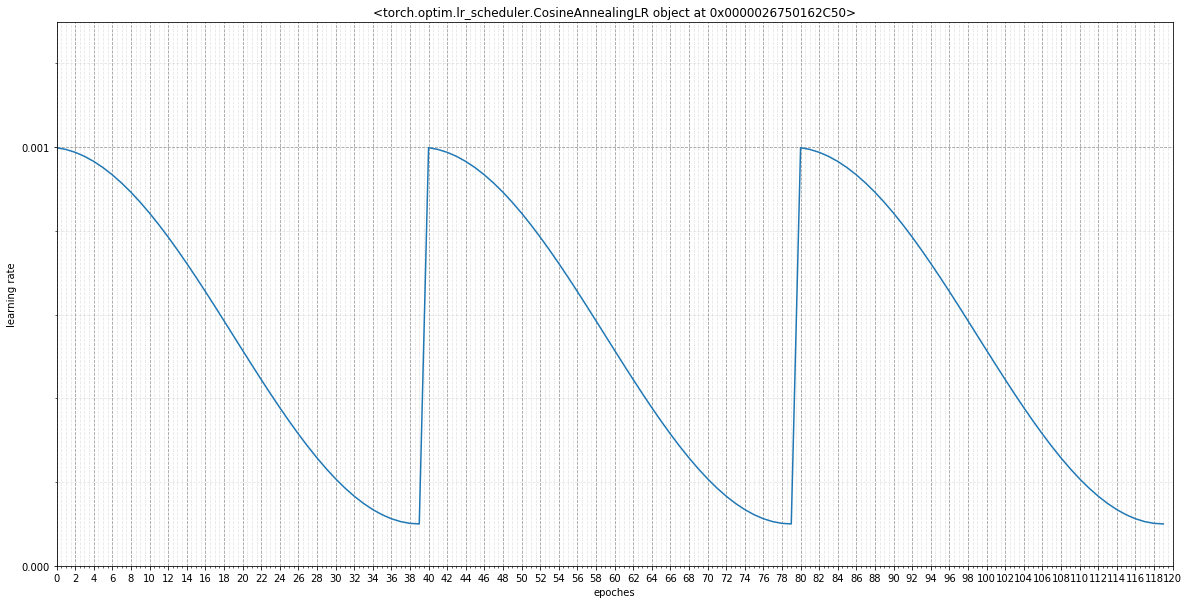

In [70]:
lr_scheduler = CosineAnnealingLR(optimizer, 40, eta_min = 0.0001,last_epoch=0)
num_epoches = 120
lrs = np.zeros((num_epoches),np.float32)
for epoch in range(0,num_epoches):
    if epoch % 40 == 0:
        lr_scheduler.last_epoch = 0       
    lr_scheduler.step()
    lr = lr_scheduler.get_lr()[0]
    lrs[epoch] = lr
    
    
    
    if lr<0:
        num_epoches = epoch
        break
    #print('epoch=%02d,  lr=%f'%(epoch,lr))
    #print(lr_scheduler.last_epoch)

#plot
fig = plt.figure(figsize = (20,10))
plot_rates(fig, lrs, num_epoches, title=str(lr_scheduler))
plt.show()


In [8]:
import pandas as pd
df = pd.read_csv('../data/train.csv')

In [9]:
df.head()

,Unnamed: 0,id,rle_mask,class
0,0,575d24d81d,NaN,1
1,1,a266a2a9df,5051 5151,0
2,2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,0
3,3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,0
4,4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,0


In [5]:
df['class'] = 0
df.loc[df['rle_mask'].isnull(),"class"] = 1

In [12]:
df.head()

,Unnamed: 0,id,rle_mask,class,filename
0,0,575d24d81d,NaN,1,575d24d81d.png
1,1,a266a2a9df,5051 5151,0,a266a2a9df.png
2,2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,0,75efad62c1.png
3,3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,0,34e51dba6a.png
4,4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,0,4875705fb0.png


In [11]:
df['filename'] = df['id']+'.png'

In [13]:
df.to_csv('../data/train.csv')

In [14]:
df = pd.read_csv('../data/submission.csv')

In [17]:
df['filename'] = df['id']+'.png'

In [18]:
df.to_csv('../data/submission.csv')
